In [1]:
import os
import pickle
from collections import Counter

import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras import Input, Model, layers, losses, callbacks, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# load data
(xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.cifar10.load_data()
classes = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
print(xtrain.shape)

(50000, 32, 32, 3)


In [4]:
def rescale(x):
    return xtrain.astype("float32") / 255.

xtrain = rescale(xtrain)
ytrain = ytrain.flatten()
xtest = rescale(xtest)
ytest = ytest.flatten()

# split into train/val/test set
Xtrain, X0, Ytrain, Y0 = train_test_split(xtrain, ytrain, train_size=10000)
Xval, X0, Yval, Y0 = train_test_split(X0, Y0, train_size=1000)
Xtest, X0, Ytest, Y0 = train_test_split(X0, Y0, train_size=1000)

print(Counter(Ytrain.flatten()))

Counter({0: 1036, 1: 1033, 3: 1029, 2: 1001, 8: 996, 9: 989, 4: 986, 7: 986, 6: 973, 5: 971})


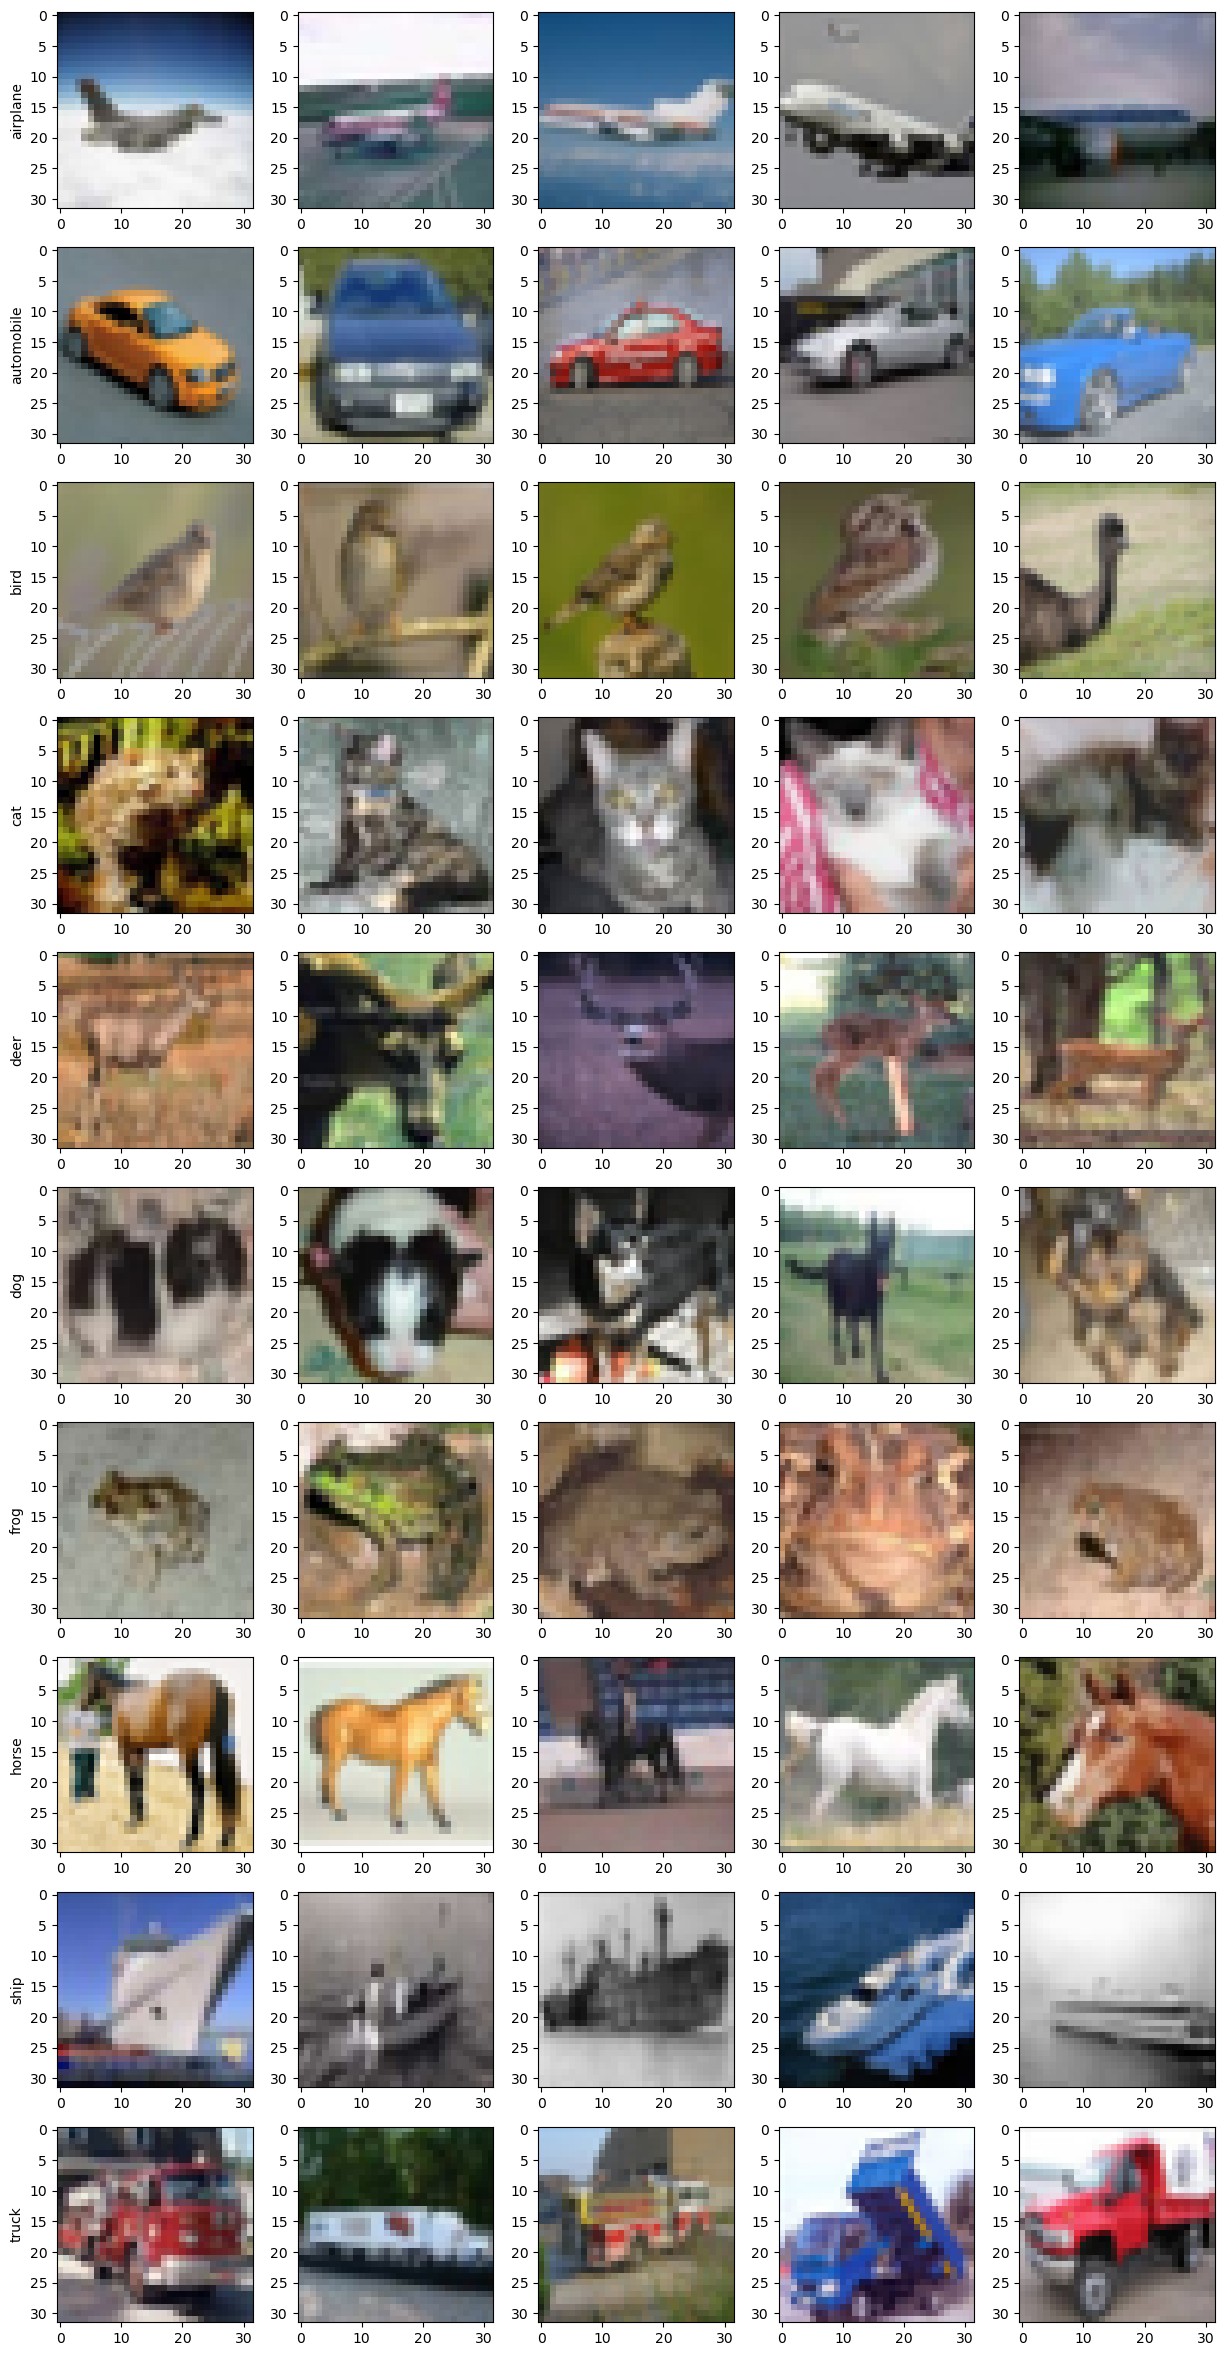

In [33]:
# plot some data points for each class
fig, ax = plt.subplots(10, 5, figsize=(15, 30))
for i in range(10):
    idxs_i = np.arange(len(Ytrain))[Ytrain==i]
    idx = np.random.choice(idxs_i, 5, replace=False)
    xs = Xtrain[idx]
    for j,x in enumerate(xs):
        ax[i,j].imshow(x)
    ax[i,0].set_ylabel(classes[i])

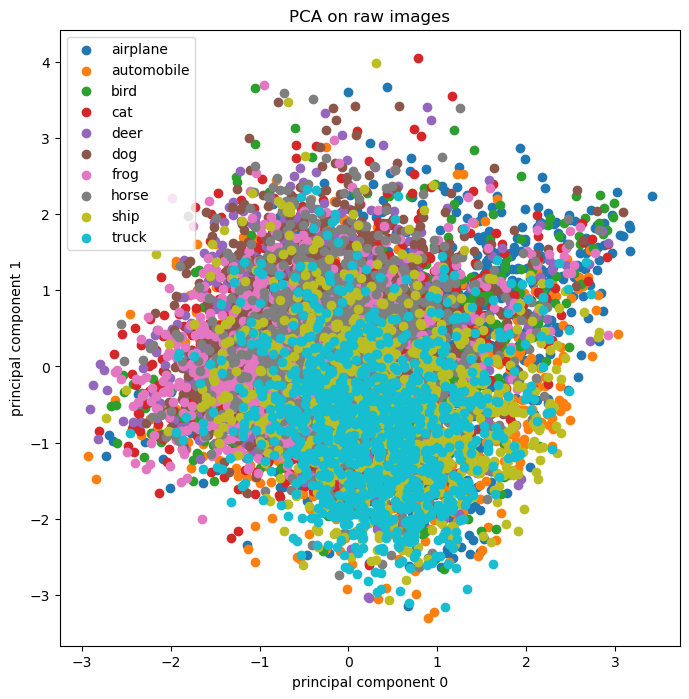

In [34]:
pre = Pipeline({
    ("scale", StandardScaler()),
    ("pca", PCA(n_components=500, whiten=True))
})

Xpre = pre.fit_transform(Xtrain.reshape((Xtrain.shape[0], -1)))
fig, ax = plt.subplots(1,1, figsize=(8,8))
for y in np.unique(Ytrain):
    ax.scatter(Xpre[Ytrain==y,0], Xpre[Ytrain==y,1])
ax.legend(classes)
ax.set_xlabel('principal component 0')
ax.set_ylabel('principal component 1')
ax.set_title('PCA on raw images');

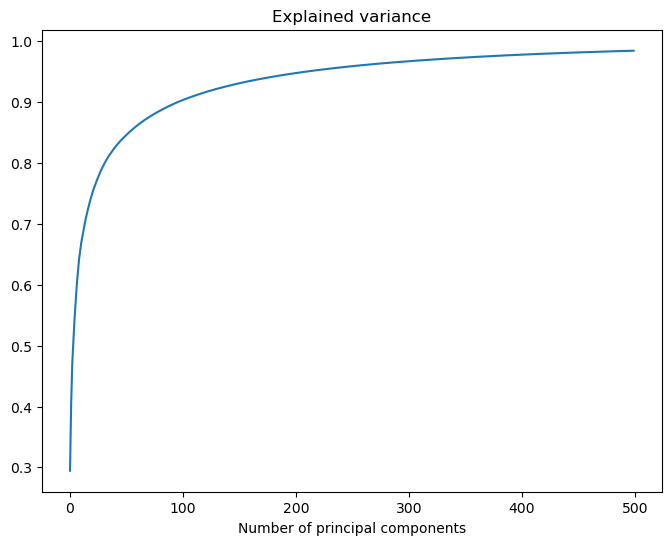

In [35]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(np.cumsum(pre['pca'].explained_variance_ratio_))
ax.set_title('Explained variance')
ax.set_xlabel('Number of principal components');

In [37]:
Xval_pre = pre.transform(Xval.reshape((1000, -1)))
results = {
    'accuracy' : [],
    'f1_score' : [],
    'precision' : [],
    'recall' : []
}
comps = [2, 5, 10, 25, 50, 75, 100, 200]
if True:
    clfs = []
    for n_components in comps:
        Xtrain2 = Xpre[:,:n_components]
        Xval2 = Xval_pre[:,:n_components]
        svm = SVC()
        svm.fit(Xtrain2, Ytrain)
        Ypred = svm.predict(Xval2)
        results['accuracy'].append(metrics.accuracy_score(Yval, Ypred, normalize=True))
        results['f1_score'].append(metrics.f1_score(Yval, Ypred, average='micro'))
        results['precision'].append(metrics.precision_score(Yval, Ypred, average='micro'))
        results['recall'].append(metrics.recall_score(Yval, Ypred, average='micro'))
        clfs.append(svm)

    with open('cifar10_svms.pkl', 'wb') as file:
        pickle.dump([comps, clfs], file)
                         

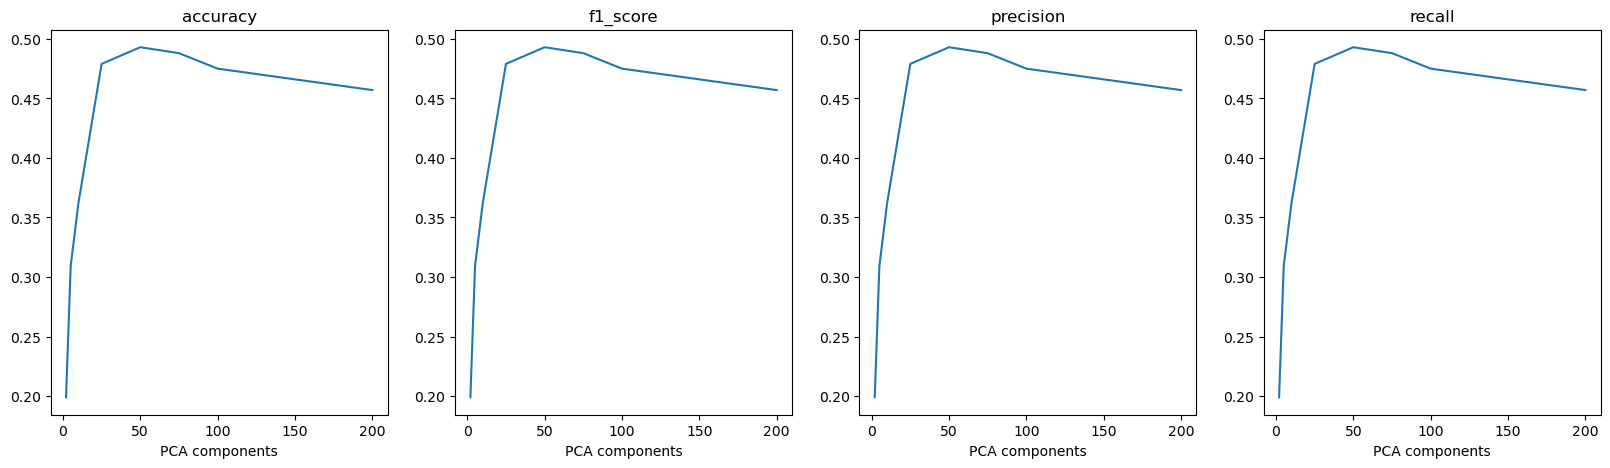

In [38]:
fig, axs = plt.subplots(1,4, figsize=(20,5))
for k,ax in zip(results.keys(), axs):
    ax.plot(comps, results[k])
    ax.set_title(k)
    ax.set_xlabel('PCA components')

In [41]:
def convnet(input_shape=(32, 32, 3), n_dense=512, n_classes=10):
    inx = Input(input_shape)
    x = layers.Conv2D(32, kernel_size=(3, 3), strides=2, padding="same", activation="relu")(inx)
    x = layers.Conv2D(64, kernel_size=(3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, kernel_size=(3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(n_classes)(x)
    return Model(inx, x)

clf = convnet()
clf.summary()

# select loss function and optimizer
loss = losses.CategoricalCrossentropy(from_logits=True)
opt = optimizers.Nadam(learning_rate=1e-3)
clf.compile(loss=loss,
            optimizer=opt,
            metrics=["accuracy"]
           )

# preprocess data: scaling of images, one-hot encoding of labels
def preprocess_tf(x, y):
    return x, tf.one_hot(y, depth=10, axis=-1)

trainset = tf.data.Dataset.from_tensor_slices((Xtrain, Ytrain)).shuffle(Xtrain.shape[0]).batch(256).map(preprocess_tf)
valset = tf.data.Dataset.from_tensor_slices((Xval, Yval)).batch(1000).map(preprocess_tf)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dense_5 (Dense)             (None, 10)                1290

In [62]:
clf.layers[4]

In [46]:
cpt = callbacks.ModelCheckpoint("cifar10_clf", save_best_only=True, monitor="val_accuracy")
hist = clf.fit(trainset,
               validation_data=valset,
               epochs=100,
               callbacks=[cpt]
               )



Epoch 1/100
38/40 [===========================>..] - ETA: 0s - loss: 2.9275e-04 - accuracy: 1.0000

INFO:tensorflow:Assets written to: cifar10_clf/assets


INFO:tensorflow:Assets written to: cifar10_clf/assets


40/40 [==============================] - 2s 38ms/step - loss: 2.9284e-04 - accuracy: 1.0000 - val_loss: 5.1073 - val_accuracy: 0.5330
Epoch 2/100
38/40 [===========================>..] - ETA: 0s - loss: 2.8168e-04 - accuracy: 1.0000

INFO:tensorflow:Assets written to: cifar10_clf/assets


INFO:tensorflow:Assets written to: cifar10_clf/assets


40/40 [==============================] - 1s 36ms/step - loss: 2.8104e-04 - accuracy: 1.0000 - val_loss: 5.1277 - val_accuracy: 0.5360
Epoch 3/100
40/40 [==============================] - 1s 27ms/step - loss: 2.7271e-04 - accuracy: 1.0000 - val_loss: 5.1423 - val_accuracy: 0.5360
Epoch 4/100
39/40 [============================>.] - ETA: 0s - loss: 2.6328e-04 - accuracy: 1.0000

INFO:tensorflow:Assets written to: cifar10_clf/assets


INFO:tensorflow:Assets written to: cifar10_clf/assets


40/40 [==============================] - 1s 36ms/step - loss: 2.6304e-04 - accuracy: 1.0000 - val_loss: 5.1537 - val_accuracy: 0.5400
Epoch 5/100
40/40 [==============================] - 1s 26ms/step - loss: 2.5288e-04 - accuracy: 1.0000 - val_loss: 5.1715 - val_accuracy: 0.5350
Epoch 6/100
40/40 [==============================] - 1s 26ms/step - loss: 2.4441e-04 - accuracy: 1.0000 - val_loss: 5.1886 - val_accuracy: 0.5360
Epoch 7/100
40/40 [==============================] - 1s 26ms/step - loss: 2.3686e-04 - accuracy: 1.0000 - val_loss: 5.2096 - val_accuracy: 0.5350
Epoch 8/100
40/40 [==============================] - 1s 26ms/step - loss: 2.2721e-04 - accuracy: 1.0000 - val_loss: 5.2182 - val_accuracy: 0.5370
Epoch 9/100
40/40 [==============================] - 1s 26ms/step - loss: 2.2044e-04 - accuracy: 1.0000 - val_loss: 5.2351 - val_accuracy: 0.5390
Epoch 10/100
40/40 [==============================] - 1s 26ms/step - loss: 2.1198e-04 - accuracy: 1.0000 - val_loss: 5.2556 - val_accura

Text(0.5, 1.0, 'Accuracy')

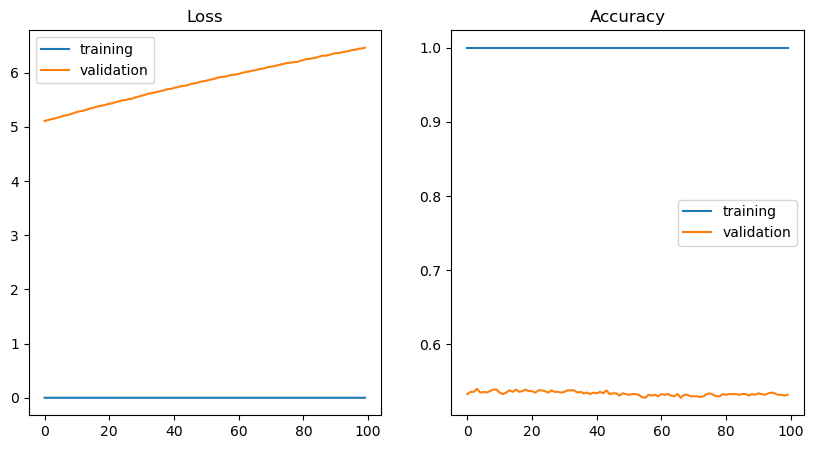

In [48]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(hist.history['loss'])
ax[0].plot(hist.history['val_loss'])
ax[0].legend(['training', 'validation'])
ax[0].set_title('Loss')
ax[1].plot(hist.history['accuracy'])
ax[1].plot(hist.history['val_accuracy'])
ax[1].legend(['training', 'validation'])
ax[1].set_title('Accuracy')

In [45]:
clf2 = tf.keras.models.load_model("cifar10_clf")
Ypred = tf.argmax(clf2.predict(Xtest), axis=-1)
print(classification_report(Ytest, Ypred))
print(confusion_matrix(Ytest, Ypred))

32/32 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.58      0.67      0.62        92
           1       0.68      0.75      0.71        93
           2       0.42      0.46      0.44        98
           3       0.37      0.39      0.38       111
           4       0.53      0.46      0.49       113
           5       0.38      0.36      0.37        91
           6       0.61      0.58      0.60        93
           7       0.54      0.55      0.54        99
           8       0.71      0.68      0.69       109
           9       0.64      0.57      0.61       101

    accuracy                           0.55      1000
   macro avg       0.55      0.55      0.55      1000
weighted avg       0.55      0.55      0.54      1000

[[62  2  5  2  1  3  0  5  9  3]
 [ 1 70  3  1  0  0  1  1  3 13]
 [11  0 45 11  8  9  5  8  0  1]
 [ 4  1 10 43 10 20 11  6  3  3]
 [ 6  2 17  7 52  7  7 10  5  0]
 [ 0  1  9 23  8 33  5 

2022-11-19 23:29:25.736039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [50]:
def make_extractor(clf, feature_layer=4):
    return Model(clf.input, clf.layers[feature_layer].output)

In [51]:
ext = make_extractor(clf2)
Xtrain2 = ext(Xtrain).numpy()
Xtest2 = ext(Xtest).numpy()

mdl = SVC()
mdl.fit(Xtrain2, Ytrain)

SVC()

In [52]:
Ypred = mdl.predict(Xtest2)
print(classification_report(Ytest, Ypred, target_names=classes))
print(confusion_matrix(Ytest, Ypred))

              precision    recall  f1-score   support

    airplane       0.64      0.68      0.66        92
  automobile       0.71      0.82      0.76        93
        bird       0.45      0.44      0.44        98
         cat       0.51      0.50      0.50       111
        deer       0.57      0.43      0.49       113
         dog       0.43      0.42      0.42        91
        frog       0.64      0.70      0.67        93
       horse       0.56      0.60      0.58        99
        ship       0.76      0.74      0.75       109
       truck       0.68      0.70      0.69       101

    accuracy                           0.60      1000
   macro avg       0.60      0.60      0.60      1000
weighted avg       0.60      0.60      0.60      1000

[[63  4  5  1  0  1  1  8  8  1]
 [ 2 76  1  0  0  0  1  0  1 12]
 [ 7  1 43 15  9  9  4  8  0  2]
 [ 1  1 10 55  9 20  9  1  3  2]
 [ 8  3 12  4 49  6  9 15  6  1]
 [ 0  1 10 15  8 38  7  9  1  2]
 [ 1  1  6  9  0  3 65  3  2  3]
 [ 3  3  4

In [63]:
# try a better classifier

def make_cifar_clf(input_shape=(32, 32, 3), n_classes=10,
                   n_dense=512, use_dropout=True,
                   use_batchnorm=True):
    inx = Input(input_shape)
    
    #conv block 0
    x = layers.Conv2D(32, (3, 3), padding="same", kernel_initializer="he_uniform", activation="relu")(inx)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), padding="same", strides=2, kernel_initializer="he_uniform", activation="relu")(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    if use_dropout:
        x = layers.Dropout(.1)(x)
    
    # conv block 1
    x = layers.Conv2D(64, (3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3,3), padding='same', strides=2, kernel_initializer='he_uniform', activation='relu')(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    if use_dropout:
        x = layers.Dropout(.2)(x)
        
    # conv block 2
    x = layers.Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3,3), padding='same', strides=2, kernel_initializer='he_uniform', activation='relu')(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    if use_dropout:
        x = layers.Dropout(.3)(x)
        
    # conv block 3    
    x = layers.Conv2D(256, (3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3,3), padding='same', strides=2, kernel_initializer='he_uniform', activation='relu')(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    if use_dropout:
        x = layers.Dropout(.4)(x)
        
    # dense layer
    x = layers.Flatten()(x)
    x = layers.Dense(n_dense, activation="relu")(x)
    if use_dropout:
        x = layers.Dropout(.5)(x)
    
    # output
    x = layers.Dense(n_classes)(x)
    
    mdl = Model(inx, x)
    
    loss = losses.CategoricalCrossentropy(from_logits=True)
    opt = optimizers.Nadam(learning_rate=1e-3)
    mdl.compile(loss=loss,
                optimizer=opt,
                metrics=["accuracy"]
               )
    return mdl


In [64]:
nets = [make_cifar_clf(use_dropout=False, use_batchnorm=False),
       make_cifar_clf(use_dropout=False, use_batchnorm=True),
       make_cifar_clf(use_dropout=True, use_batchnorm=True),
       ]

keys = ["default", "batchnorm", "batchnorm+dropout"]
convnets = dict(zip(keys, nets))

predictions = {}

for mdl_name, mdl in convnets.items():
    cpt = callbacks.ModelCheckpoint("cifar10_"+mdl_name, save_best_only=True, monitor="val_accuracy")
    mdl.fit(trainset, validation_data=valset, epochs=10, callbacks=[cpt])
    Ypred = tf.argmax(mdl.predict(Xtest), axis=-1)
    predictions[mdl_name] = Ypred
                                    

Epoch 1/10


2022-11-20 09:21:09.049238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - ETA: 0s - loss: 2.3534 - accuracy: 0.1584

2022-11-20 09:21:13.231518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: cifar10_default/assets


INFO:tensorflow:Assets written to: cifar10_default/assets


40/40 [==============================] - 6s 92ms/step - loss: 2.3534 - accuracy: 0.1584 - val_loss: 2.6398 - val_accuracy: 0.1160
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 2.0071 - accuracy: 0.2622

INFO:tensorflow:Assets written to: cifar10_default/assets


INFO:tensorflow:Assets written to: cifar10_default/assets


40/40 [==============================] - 3s 63ms/step - loss: 2.0071 - accuracy: 0.2622 - val_loss: 2.7508 - val_accuracy: 0.1810
Epoch 3/10
39/40 [============================>.] - ETA: 0s - loss: 1.8914 - accuracy: 0.3144

INFO:tensorflow:Assets written to: cifar10_default/assets


INFO:tensorflow:Assets written to: cifar10_default/assets


40/40 [==============================] - 2s 60ms/step - loss: 1.8910 - accuracy: 0.3146 - val_loss: 2.0280 - val_accuracy: 0.3000
Epoch 4/10
40/40 [==============================] - 2s 44ms/step - loss: 1.6368 - accuracy: 0.3992 - val_loss: 1.9203 - val_accuracy: 0.2660
Epoch 5/10
40/40 [==============================] - ETA: 0s - loss: 1.5615 - accuracy: 0.4340

INFO:tensorflow:Assets written to: cifar10_default/assets


INFO:tensorflow:Assets written to: cifar10_default/assets


40/40 [==============================] - 3s 64ms/step - loss: 1.5615 - accuracy: 0.4340 - val_loss: 1.9444 - val_accuracy: 0.3680
Epoch 6/10
39/40 [============================>.] - ETA: 0s - loss: 1.4372 - accuracy: 0.4850

INFO:tensorflow:Assets written to: cifar10_default/assets


INFO:tensorflow:Assets written to: cifar10_default/assets


40/40 [==============================] - 2s 60ms/step - loss: 1.4369 - accuracy: 0.4850 - val_loss: 2.0333 - val_accuracy: 0.3740
Epoch 7/10
40/40 [==============================] - 2s 43ms/step - loss: 1.3171 - accuracy: 0.5281 - val_loss: 3.5137 - val_accuracy: 0.2880
Epoch 8/10
40/40 [==============================] - 2s 44ms/step - loss: 1.5417 - accuracy: 0.4608 - val_loss: 2.1652 - val_accuracy: 0.3520
Epoch 9/10
40/40 [==============================] - 2s 45ms/step - loss: 1.1888 - accuracy: 0.5804 - val_loss: 2.1027 - val_accuracy: 0.3680
Epoch 10/10
39/40 [============================>.] - ETA: 0s - loss: 1.0728 - accuracy: 0.6194

INFO:tensorflow:Assets written to: cifar10_default/assets


INFO:tensorflow:Assets written to: cifar10_default/assets


 1/32 [..............................] - ETA: 3s

2022-11-20 09:21:33.785356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Epoch 1/10


2022-11-20 09:21:35.019388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - ETA: 0s - loss: 1.9173 - accuracy: 0.3331

2022-11-20 09:21:43.194559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: cifar10_batchnorm/assets


INFO:tensorflow:Assets written to: cifar10_batchnorm/assets


40/40 [==============================] - 11s 154ms/step - loss: 1.9173 - accuracy: 0.3331 - val_loss: 2.1588 - val_accuracy: 0.2480
Epoch 2/10
40/40 [==============================] - 3s 63ms/step - loss: 1.0268 - accuracy: 0.6463 - val_loss: 2.2378 - val_accuracy: 0.1410
Epoch 3/10
40/40 [==============================] - 2s 60ms/step - loss: 0.5166 - accuracy: 0.8358 - val_loss: 3.2178 - val_accuracy: 0.1410
Epoch 4/10
40/40 [==============================] - 2s 61ms/step - loss: 0.2929 - accuracy: 0.9149 - val_loss: 4.4554 - val_accuracy: 0.1960
Epoch 5/10
40/40 [==============================] - ETA: 0s - loss: 0.2064 - accuracy: 0.9436

INFO:tensorflow:Assets written to: cifar10_batchnorm/assets


INFO:tensorflow:Assets written to: cifar10_batchnorm/assets


40/40 [==============================] - 4s 95ms/step - loss: 0.2064 - accuracy: 0.9436 - val_loss: 2.5231 - val_accuracy: 0.3260
Epoch 6/10
40/40 [==============================] - ETA: 0s - loss: 0.1192 - accuracy: 0.9676

INFO:tensorflow:Assets written to: cifar10_batchnorm/assets


INFO:tensorflow:Assets written to: cifar10_batchnorm/assets


40/40 [==============================] - 4s 96ms/step - loss: 0.1192 - accuracy: 0.9676 - val_loss: 2.8672 - val_accuracy: 0.3320
Epoch 7/10
40/40 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9948

INFO:tensorflow:Assets written to: cifar10_batchnorm/assets


INFO:tensorflow:Assets written to: cifar10_batchnorm/assets


40/40 [==============================] - 4s 93ms/step - loss: 0.0288 - accuracy: 0.9948 - val_loss: 2.6065 - val_accuracy: 0.3940
Epoch 8/10
40/40 [==============================] - 2s 59ms/step - loss: 0.0303 - accuracy: 0.9939 - val_loss: 2.8667 - val_accuracy: 0.3880
Epoch 9/10
40/40 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9992

INFO:tensorflow:Assets written to: cifar10_batchnorm/assets


INFO:tensorflow:Assets written to: cifar10_batchnorm/assets


40/40 [==============================] - 4s 91ms/step - loss: 0.0070 - accuracy: 0.9992 - val_loss: 3.0369 - val_accuracy: 0.3990
Epoch 10/10
40/40 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 0.9991

INFO:tensorflow:Assets written to: cifar10_batchnorm/assets


INFO:tensorflow:Assets written to: cifar10_batchnorm/assets


40/40 [==============================] - 4s 90ms/step - loss: 0.0079 - accuracy: 0.9991 - val_loss: 2.8380 - val_accuracy: 0.4190


2022-11-20 09:22:13.366916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
Epoch 1/10


2022-11-20 09:22:14.894234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - ETA: 0s - loss: 2.6611 - accuracy: 0.1997

2022-11-20 09:22:24.286822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: cifar10_batchnorm+dropout/assets


INFO:tensorflow:Assets written to: cifar10_batchnorm+dropout/assets


40/40 [==============================] - 12s 197ms/step - loss: 2.6611 - accuracy: 0.1997 - val_loss: 2.2082 - val_accuracy: 0.1660
Epoch 2/10
40/40 [==============================] - 3s 75ms/step - loss: 1.9128 - accuracy: 0.3132 - val_loss: 2.4819 - val_accuracy: 0.1460
Epoch 3/10
40/40 [==============================] - 3s 72ms/step - loss: 1.7098 - accuracy: 0.3772 - val_loss: 2.9724 - val_accuracy: 0.1030
Epoch 4/10
40/40 [==============================] - ETA: 0s - loss: 1.6085 - accuracy: 0.4036

INFO:tensorflow:Assets written to: cifar10_batchnorm+dropout/assets


INFO:tensorflow:Assets written to: cifar10_batchnorm+dropout/assets


40/40 [==============================] - 4s 105ms/step - loss: 1.6085 - accuracy: 0.4036 - val_loss: 2.1076 - val_accuracy: 0.2760
Epoch 5/10
40/40 [==============================] - ETA: 0s - loss: 1.5149 - accuracy: 0.4498

INFO:tensorflow:Assets written to: cifar10_batchnorm+dropout/assets


INFO:tensorflow:Assets written to: cifar10_batchnorm+dropout/assets


40/40 [==============================] - 4s 106ms/step - loss: 1.5149 - accuracy: 0.4498 - val_loss: 2.2331 - val_accuracy: 0.2920
Epoch 6/10
40/40 [==============================] - ETA: 0s - loss: 1.4331 - accuracy: 0.4736

INFO:tensorflow:Assets written to: cifar10_batchnorm+dropout/assets


INFO:tensorflow:Assets written to: cifar10_batchnorm+dropout/assets


40/40 [==============================] - 4s 104ms/step - loss: 1.4331 - accuracy: 0.4736 - val_loss: 1.8837 - val_accuracy: 0.3500
Epoch 7/10
40/40 [==============================] - ETA: 0s - loss: 1.3889 - accuracy: 0.4970

INFO:tensorflow:Assets written to: cifar10_batchnorm+dropout/assets


INFO:tensorflow:Assets written to: cifar10_batchnorm+dropout/assets


40/40 [==============================] - 4s 107ms/step - loss: 1.3889 - accuracy: 0.4970 - val_loss: 1.7751 - val_accuracy: 0.3930
Epoch 8/10
40/40 [==============================] - ETA: 0s - loss: 1.3239 - accuracy: 0.5176

INFO:tensorflow:Assets written to: cifar10_batchnorm+dropout/assets


INFO:tensorflow:Assets written to: cifar10_batchnorm+dropout/assets


40/40 [==============================] - 4s 101ms/step - loss: 1.3239 - accuracy: 0.5176 - val_loss: 1.5518 - val_accuracy: 0.4570
Epoch 9/10
40/40 [==============================] - 3s 65ms/step - loss: 1.2537 - accuracy: 0.5419 - val_loss: 2.2375 - val_accuracy: 0.3620
Epoch 10/10
 1/32 [..............................] - ETA: 6s

2022-11-20 09:22:58.053679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step


In [65]:
# load best models and predict on test set
best_nets = {}
for k in predictions.keys():
    mdl = tf.keras.models.load_model("cifar10_"+k)
    best_nets[k] = mdl
    Ypred = tf.argmax(mdl.predict(Xtest), axis=-1)
    print(k, metrics.accuracy_score(Ytest, Ypred))

 1/32 [..............................] - ETA: 7s

2022-11-20 09:26:02.185832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 9ms/step
default 0.499
 2/32 [>.............................] - ETA: 1s

2022-11-20 09:26:03.626324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
batchnorm 0.443
 1/32 [..............................] - ETA: 6s

2022-11-20 09:26:04.968191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
batchnorm+dropout 0.459


In [67]:
# try data augmentation
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             rotation_range=20)
it_train = datagen.flow(Xtrain, tf.one_hot(Ytrain, depth=10), batch_size=256)

cpt = callbacks.ModelCheckpoint("cifar10_bn_do_da", save_best_only=True, monitor="val_accuracy")
mdl = make_cifar_clf()
hist = mdl.fit(it_train,
               validation_data=valset,
               steps_per_epoch=10000//256,
               epochs=10,
               callbacks=[cpt]
              )

Epoch 1/10


2022-11-20 09:31:37.292457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - ETA: 0s - loss: 2.6749 - accuracy: 0.1955

2022-11-20 09:31:49.454605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: cifar10_bn_do_da/assets


INFO:tensorflow:Assets written to: cifar10_bn_do_da/assets


39/39 [==============================] - 15s 240ms/step - loss: 2.6749 - accuracy: 0.1955 - val_loss: 2.1935 - val_accuracy: 0.1910
Epoch 2/10
39/39 [==============================] - ETA: 0s - loss: 2.0123 - accuracy: 0.2865

INFO:tensorflow:Assets written to: cifar10_bn_do_da/assets


INFO:tensorflow:Assets written to: cifar10_bn_do_da/assets


39/39 [==============================] - 4s 112ms/step - loss: 2.0123 - accuracy: 0.2865 - val_loss: 2.1274 - val_accuracy: 0.2130
Epoch 3/10
39/39 [==============================] - ETA: 0s - loss: 1.8482 - accuracy: 0.3242

INFO:tensorflow:Assets written to: cifar10_bn_do_da/assets


INFO:tensorflow:Assets written to: cifar10_bn_do_da/assets


39/39 [==============================] - 4s 110ms/step - loss: 1.8482 - accuracy: 0.3242 - val_loss: 1.9328 - val_accuracy: 0.2950
Epoch 4/10
39/39 [==============================] - ETA: 0s - loss: 1.7392 - accuracy: 0.3536

INFO:tensorflow:Assets written to: cifar10_bn_do_da/assets


INFO:tensorflow:Assets written to: cifar10_bn_do_da/assets


39/39 [==============================] - 4s 102ms/step - loss: 1.7392 - accuracy: 0.3536 - val_loss: 1.8708 - val_accuracy: 0.3230
Epoch 5/10
39/39 [==============================] - ETA: 0s - loss: 1.6917 - accuracy: 0.3726

INFO:tensorflow:Assets written to: cifar10_bn_do_da/assets


INFO:tensorflow:Assets written to: cifar10_bn_do_da/assets


39/39 [==============================] - 4s 105ms/step - loss: 1.6917 - accuracy: 0.3726 - val_loss: 1.8232 - val_accuracy: 0.3630
Epoch 6/10
39/39 [==============================] - ETA: 0s - loss: 1.6496 - accuracy: 0.3936

INFO:tensorflow:Assets written to: cifar10_bn_do_da/assets


INFO:tensorflow:Assets written to: cifar10_bn_do_da/assets


39/39 [==============================] - 4s 108ms/step - loss: 1.6496 - accuracy: 0.3936 - val_loss: 1.7407 - val_accuracy: 0.3950
Epoch 7/10
39/39 [==============================] - ETA: 0s - loss: 1.5974 - accuracy: 0.4154

INFO:tensorflow:Assets written to: cifar10_bn_do_da/assets


INFO:tensorflow:Assets written to: cifar10_bn_do_da/assets


39/39 [==============================] - 4s 104ms/step - loss: 1.5974 - accuracy: 0.4154 - val_loss: 1.5568 - val_accuracy: 0.4300
Epoch 8/10
39/39 [==============================] - ETA: 0s - loss: 1.5743 - accuracy: 0.4207

INFO:tensorflow:Assets written to: cifar10_bn_do_da/assets


INFO:tensorflow:Assets written to: cifar10_bn_do_da/assets


39/39 [==============================] - 4s 108ms/step - loss: 1.5743 - accuracy: 0.4207 - val_loss: 1.5565 - val_accuracy: 0.4320
Epoch 9/10
39/39 [==============================] - ETA: 0s - loss: 1.5238 - accuracy: 0.4421

INFO:tensorflow:Assets written to: cifar10_bn_do_da/assets


INFO:tensorflow:Assets written to: cifar10_bn_do_da/assets


39/39 [==============================] - 4s 101ms/step - loss: 1.5238 - accuracy: 0.4421 - val_loss: 1.4250 - val_accuracy: 0.4740
Epoch 10/10
39/39 [==============================] - ETA: 0s - loss: 1.4958 - accuracy: 0.4550

INFO:tensorflow:Assets written to: cifar10_bn_do_da/assets


INFO:tensorflow:Assets written to: cifar10_bn_do_da/assets


39/39 [==============================] - 4s 107ms/step - loss: 1.4958 - accuracy: 0.4550 - val_loss: 1.4129 - val_accuracy: 0.4870


Text(0.5, 1.0, 'Accuracy')

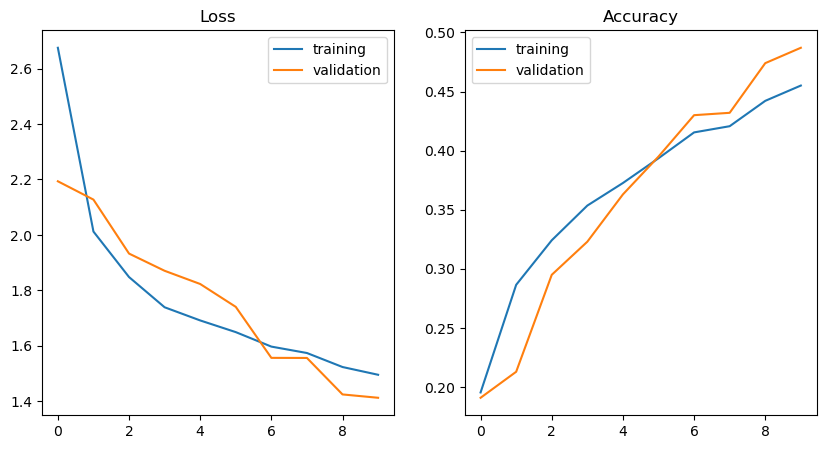

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(hist.history["loss"])
ax[0].plot(hist.history['val_loss'])
ax[0].legend(['training', 'validation'])
ax[0].set_title('Loss')
ax[1].plot(hist.history['accuracy'])
ax[1].plot(hist.history['val_accuracy'])
ax[1].legend(['training', 'validation'])
ax[1].set_title('Accuracy')

In [70]:
Ypred = tf.argmax(mdl.predict(Xtest), axis=-1)
print(metrics.classification_report(Ytest, Ypred))

2022-11-20 09:34:35.006552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.65      0.34      0.44        92
           1       0.51      0.72      0.60        93
           2       0.37      0.18      0.24        98
           3       0.42      0.19      0.26       111
           4       0.45      0.43      0.44       113
           5       0.34      0.42      0.38        91
           6       0.43      0.72      0.54        93
           7       0.58      0.52      0.55        99
           8       0.59      0.75      0.66       109
           9       0.58      0.68      0.63       101

    accuracy                           0.49      1000
   macro avg       0.49      0.50      0.47      1000
weighted avg       0.49      0.49      0.47      1000



In [71]:
mdl2 = tf.keras.models.load_model("cifar10_bn_do_da")
Ypred = tf.argmax(mdl2.predict(Xtest), axis=-1)
print(metrics.classification_report(Ytest, Ypred))

 1/32 [..............................] - ETA: 6s

2022-11-20 09:35:42.838487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
              precision    recall  f1-score   support

           0       0.65      0.34      0.44        92
           1       0.51      0.72      0.60        93
           2       0.37      0.18      0.24        98
           3       0.42      0.19      0.26       111
           4       0.45      0.43      0.44       113
           5       0.34      0.42      0.38        91
           6       0.43      0.72      0.54        93
           7       0.58      0.52      0.55        99
           8       0.59      0.75      0.66       109
           9       0.58      0.68      0.63       101

    accuracy                           0.49      1000
   macro avg       0.49      0.50      0.47      1000
weighted avg       0.49      0.49      0.47      1000



In [72]:
mdl2.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_97 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_56 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_98 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_57 (Bat  (None, 16, 16, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_20 (Dropout)        (None, 16, 16, 32)        0  

In [74]:
# PCA on images and image features

ext2 = make_extractor(mdl2, feature_layer=21)
Xtrain_features = ext2(Xtrain)

Fpca = PCA(n_components=3, whiten=True).fit_transform(Xtrain2)
Fpca2 = PCA(n_components=3, whiten=True).fit_transform(Xtrain_features)

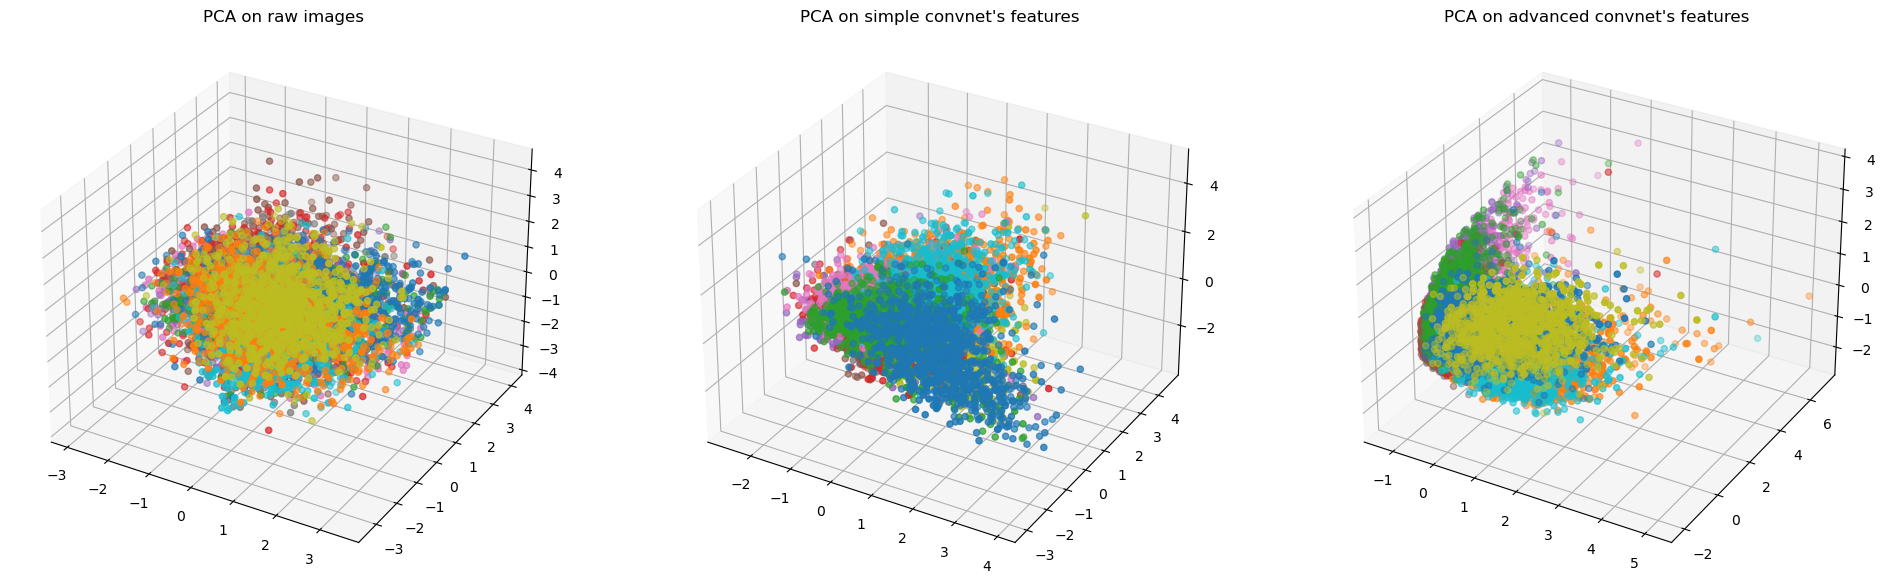

In [75]:
fig = plt.figure(figsize=(24,8))
ax0 = fig.add_subplot(131, projection='3d')
ax1 = fig.add_subplot(132, projection='3d')
ax2 = fig.add_subplot(133, projection='3d')

for y,yn in enumerate(classes):
    ax0.scatter(Xpre[Ytrain==y, 0], Xpre[Ytrain==y, 1], Xpre[Ytrain==y, 2])
    ax0.set_title('PCA on raw images')
    ax1.scatter(Fpca[Ytrain==y, 0], Fpca[Ytrain==y, 1], Fpca[Ytrain==y, 2])
    ax1.set_title("PCA on simple convnet's features")
    ax2.scatter(Fpca2[Ytrain==y, 0], Fpca2[Ytrain==y, 1], Fpca2[Ytrain==y, 2])
    ax2.set_title("PCA on advanced convnet's features")